In [1]:
import numpy as np
import csv
from IPython.display import display, Math

from scipy.optimize import minimize

from matplotlib import pyplot as plt

from libration_sense import *
from daceypy import DA

import matplotlib.pyplot as plt

"""функция по формуле Маркова-Гаусса вычисляет оптимальное значение коэффициентов в МНК

    Returns:
        tuple: (alpha_star, rmin_max) - коэффициенты и параметр нормировки на единицу для восстановления размерной формулы
    """

def alpha_finder(n: float, orbit_type: str,
                 number_of_orbit: int,
                 xf: DA,
                 grid_density: int = 5,
                 number_of_halo_point: int | None = None) -> tuple:
    # Создаем сетку значений
    std_pos_values = np.linspace(0, km2du(8), grid_density)  # от 0 до 8 км
    std_vel_values = np.linspace(0, kmS2vu(0.05e-3), grid_density)  # от 0 до 0.05 м / с

    # Данные для нормировки
    pos_max = np.max(std_pos_values)
    vel_max = np.max(std_vel_values)

    # Генерируем матрицу A и вектор y
    N = grid_density**2
    A = np.zeros((N, 2))
    y = np.zeros(N)

    # Заполняем нормированную матрицу A и вектор y
    index = 0
    for std_pos in std_pos_values:
        for std_vel in std_vel_values:
            A[index] = [std_pos / pos_max, std_vel / vel_max]
            y[index] = get_maxdeviation_wo_integrate(orbit_type, number_of_orbit, xf, std_pos, std_vel, number_of_halo_point=number_of_halo_point)
            index += 1

    deviation_max = np.max(y)

    y_normed = y / deviation_max
    y_powered = np.power(y_normed, n)
    A_powered = np.power(A, n)
    alpha_star = np.linalg.inv(A_powered.T @ A_powered) @ A_powered.T @ y_powered

    return alpha_star, deviation_max

def alpha_finder_of_n(A_normed, y, n):
    rmin_max = np.max(y)
    y_normed = y / rmin_max
    y_powered = np.power(y_normed, n)
    A_powered = np.power(A_normed, n)
    return np.linalg.inv(A_powered.T @ A_powered) @ A_powered.T @ y_powered, rmin_max


def n_finder(orbit_type: str,
             number_of_orbit: int,
             xfinal: DA,
             grid_density: int = 5,
             number_of_halo_point: int | None = None) -> float:
    """оптимизация функционала J2 по n

    Args:
        orbit (np.ndarray): [a, e, i, omega, Omega]
        xfinal (DA): конечная точка в TBP
        m (int, optional): размер (плотность) сетки значений навигационных неточностей

    Returns:
        float: степень в формуле для d
    """
    std_pos_values = np.linspace(0, km2du(3), grid_density)  # от 0 до 8 км
    std_vel_values = np.linspace(0, kmS2vu(0.03e-3), grid_density)  # от 0 до 0.05 м / с

    # Генерируем матрицу A и вектор y
    N = grid_density**2
    A = np.zeros((N, 2))
    y_du = np.zeros(N)


    pos_max = np.max(std_pos_values)
    vel_max = np.max(std_vel_values)

    # Заполняем A и y
    index = 0
    for std_pos in std_pos_values:
        for std_vel in std_vel_values:
            A[index] = [std_pos / pos_max, std_vel / vel_max]
            y_du[index] = get_maxdeviation_wo_integrate(orbit_type, number_of_orbit, xfinal, std_pos, std_vel, amount_of_points=11000, number_of_halo_point=number_of_halo_point)
            index += 1
        print('col done')

    # print("Массив данных заполнен")

    y_normed = y_du / np.max(y_du)
    A_normed_du_and_vu = A

    def loss(n):
        y_powered = np.power(y_normed, n)
        A_powered = np.power(A, n)
        alpha_star = np.linalg.inv(A_powered.T @ A_powered) @ A_powered.T @ y_powered
        core = np.power(y_powered - np.dot(A_powered, alpha_star), 2)
        return np.sum(core) / np.shape(y_powered)[0]

    _x = np.linspace(0.0001, 5, 200)
    plt.plot(_x, [loss(x) for x in _x])
    plt.show()

    # Ограничения на n
    bounds = [(0.000001, None)]

    # Начальное приближение
    n_initial = 2.1

    # Метод сопряжённых направлений
    n_opt = minimize(loss, n_initial, method='Powell', bounds=bounds)

    return n_opt.x[0], A_normed_du_and_vu, y_du

In [2]:
number_of_halo_point = 600
orbit_type = 'L1'
orbit_number = 110

[ 0.89722442 -0.07415238 -0.05127859 -0.04736271 -0.20523854  0.16522684]
IS:  daceypy.array
T:  <class 'numpy.float64'>
col done
col done
col done
col done
col done
col done
col done
col done
col done
col done
col done
col done
col done
col done
col done
col done
col done
col done
col done
col done
col done


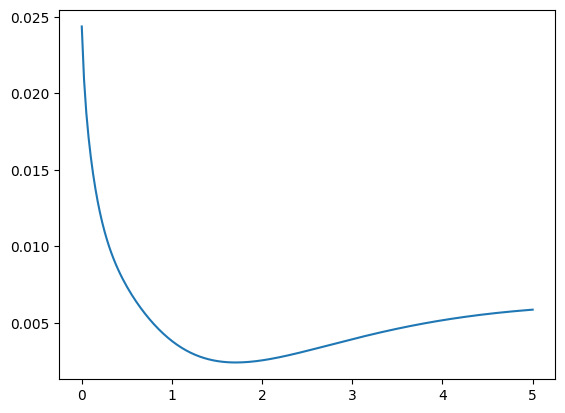

Степень n = 1.707710662347576


In [3]:
xfinal = get_xf(orbit_type, orbit_number, number_of_halo_point=number_of_halo_point)
n, A_normed, y_du = n_finder(orbit_type, orbit_number, xfinal, grid_density=21, number_of_halo_point=number_of_halo_point)
print('Степень n = ', n, sep='')
alpha, deviation_max = alpha_finder_of_n(A_normed, y_du, n)

In [8]:
n=2
alpha, deviation_max = alpha_finder_of_n(A_normed, y_du, n)
def deviation_analytic(n, alpha, std_pos_normed, std_vel_normed):
    return np.power(alpha[0]*np.power(std_pos_normed, n) + alpha[1]*np.power(std_vel_normed, n), 1/n)

formula = f"d = \\sqrt[{np.around(n, 4)}]{{{np.around(alpha[0], 2)}\\cdot \\sigma_{{pos}}^{{{np.around(n, 4)}}} + {np.around(alpha[1], 2)}\\cdot \\sigma_{{vel}}^{{{np.around(n, 4)}}}}}\\cdot{np.around(du2km(deviation_max), 3)} \\ [km]"

std_pos, std_vel = km2du(1.98), kmS2vu(0.019e-3)
std_pos_max, std_vel_max = km2du(3), kmS2vu(0.03e-3)

np.random.seed(42)
print(f"Пробная точка: [sigma_pos = {np.around(du2km(std_pos), 1)} км, sigma_vel = {vu2kms(std_vel)*1000} м/с]")
print(f"Крайние значения данных: [sigma_pos_max = {3} км, sigma_vel_max = {0.03} м/с]")
print('Точное значение: ', du2km(get_maxdeviation_wo_integrate(orbit_type, orbit_number, xfinal, std_pos, std_vel, amount_of_points=11000, number_of_halo_point=number_of_halo_point)))
print('Значение, вычисленное по аппроксимирующей формуле: ', deviation_analytic(n, alpha, std_pos/std_pos_max, std_vel/std_vel_max) * du2km(deviation_max))
display(Math(formula))

Пробная точка: [sigma_pos = 2.0 км, sigma_vel = 0.019 м/с]
Крайние значения данных: [sigma_pos_max = 3 км, sigma_vel_max = 0.03 м/с]
Точное значение:  6078.924499238626
Значение, вычисленное по аппроксимирующей формуле:  6254.164111010246


<IPython.core.display.Math object>